In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp, stats
import pandas as pd
import os
import sys
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

from edm.utils.measures import perf_measure, calculate_output_statistics, get_bootstrap_metrics


In [2]:
pd.set_option('display.max_columns', None)


# Patient Characteristics

In [ ]:
df_cohort = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.csv")
df_cohort.head(3)

In [4]:
df_cohort[df_cohort["Case_for_train"] == 1].shape

(1057, 79)

In [5]:
df_cohort[df_cohort["Max_trop"] > 0.055].shape

(1057, 79)

In [6]:
df_cohort.groupby("CSN").mean().shape

(10874, 43)

In [7]:
df_cohort.shape

(10874, 79)

In [8]:
df_train = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.train.txt", sep="\t")
df_val = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.val.txt", sep="\t")
df_test = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.test.txt", sep="\t")

In [9]:
df = pd.concat([df_train, df_val, df_test])

In [10]:
df.shape

(10874, 79)

In [12]:
df_merged = df

In [13]:
df_merged_acs = df[df["Case_for_train"] == 1]
df_merged_nonacs = df[df["Case_for_train"] == 0]

In [14]:
df_merged_acs.shape

(1057, 79)

In [15]:
df_merged_nonacs.shape

(9817, 79)

In [16]:
df[df["Gender"] == "M"].shape

(5291, 79)

In [17]:
df[df["Gender"] == "F"].shape

(5580, 79)

In [18]:
sum(df["CC_CP_SOB"])

3729

#### df_merged.describe()

In [19]:
df_merged_acs[df_merged_acs["Gender"] == "M"].shape

(611, 79)

In [20]:
df_merged_acs[df_merged_acs["Gender"] == "F"].shape

(444, 79)

In [21]:
sum(df_merged_acs["CC_CP_SOB"])

413

In [24]:
# ECG Length hours
(df_merged_acs["recommended_trim_end_sec"]/3600 - df_merged_acs["recommended_trim_start_sec"]/3600).describe()

count    1057.000000
mean        2.182036
std         1.782569
min         0.005556
25%         0.780278
50%         1.777500
75%         3.119444
max        11.417778
dtype: float64

In [25]:
# ECG Length hours
(df_merged_nonacs["recommended_trim_end_sec"]/3600 - df_merged_nonacs["recommended_trim_start_sec"]/3600).describe()

count    9817.000000
mean        2.483615
std         1.757922
min         0.004167
25%         1.192222
50%         2.167222
75%         3.416389
max        16.074167
dtype: float64

In [26]:
df_merged_nonacs[df_merged_nonacs["Gender"] == "M"].shape

(4680, 79)

In [27]:
df_merged_nonacs[df_merged_nonacs["Gender"] == "F"].shape

(5136, 79)

#### How many patients with myocardial injury have negative first trop

In [28]:
df_neg_first_trop = df_merged_acs[df_merged_acs["First_trop"] < 0.055]
df_neg_first_trop.shape

(91, 79)

In [29]:
df_pos_first_trop = df_merged_acs[df_merged_acs["First_trop"] >= 0.055]
df_pos_first_trop.shape

(966, 79)

#### Among Negative First Trop Patients - when was first pos trop?

In [31]:
df_neg_first_trop.shape

(91, 79)

In [32]:
df_neg_first_trop = df_neg_first_trop.merge(df_cohort, how="left", left_on="patient_id", right_on="CSN")
df_neg_first_trop.shape

(91, 158)

In [ ]:
df_neg_first_trop.head(3)

In [34]:
time_diff = pd.to_datetime(df_neg_first_trop["Max_trop_result_time_x"]) - pd.to_datetime(df_neg_first_trop["Arrival_time_x"])
sec_diff = time_diff.astype('timedelta64[s]')

In [35]:
sec_diff.describe()

count       91.000000
mean     22432.087912
std       9640.341109
min       7860.000000
25%      15570.000000
50%      19680.000000
75%      27120.000000
max      61800.000000
dtype: float64

#### Duration Analysis

In [36]:
df_merged_acs["trim_length"].describe()

count     1057.000000
mean      7855.329234
std       6417.248505
min         20.000000
25%       2809.000000
50%       6399.000000
75%      11230.000000
max      41104.000000
Name: trim_length, dtype: float64

In [37]:
df_merged_nonacs["trim_length"].describe()


count     9817.000000
mean      8941.013242
std       6328.517878
min         15.000000
25%       4292.000000
50%       7802.000000
75%      12299.000000
max      57867.000000
Name: trim_length, dtype: float64

In [38]:
acs_std = df_merged_acs["trim_length"].describe()["std"]
acs_std

6417.248505406262

In [39]:
nonacs_std = df_merged_nonacs["trim_length"].describe()["std"]
nonacs_std

6328.517877827278

In [40]:
# CI difference in populations
# https://www.dummies.com/education/math/statistics/creating-a-confidence-interval-for-the-difference-of-two-means-with-known-standard-deviations/
import math
ci_diff = 1.96 * math.sqrt(((acs_std ** 2) / 1057) + ((nonacs_std ** 2) / 9817))
ci_diff

406.62329726741666

In [41]:
df_merged_nonacs["trim_length"].describe()["50%"] - df_merged_acs["trim_length"].describe()["50%"]

1403.0

In [42]:
1403.0/3600

0.38972222222222225

In [43]:
(1403.0 - 406.62329726741666)/3600

0.2767713063146065

In [44]:
(1403.0 + 406.62329726741666)/3600

0.5026731381298379

#### ED Stay

In [45]:
df_merged_acs["ED_LOS"].describe()

count    1050.000000
mean        6.906895
std         3.004102
min         0.350000
25%         4.855000
50%         6.470000
75%         8.300000
max        28.230000
Name: ED_LOS, dtype: float64

In [46]:
df_merged_nonacs["ED_LOS"].describe()


count    9793.000000
mean        6.211038
std         2.891980
min         0.470000
25%         4.270000
50%         5.750000
75%         7.570000
max        50.620000
Name: ED_LOS, dtype: float64

In [47]:
acs_std = df_merged_acs["ED_LOS"].describe()["std"]
acs_std

3.004102323608724

In [48]:
nonacs_std = df_merged_nonacs["ED_LOS"].describe()["std"]
nonacs_std

2.891980229271248

In [49]:
# CI difference in populations
# https://www.dummies.com/education/math/statistics/creating-a-confidence-interval-for-the-difference-of-two-means-with-known-standard-deviations/
import math
ci_diff = 1.96 * math.sqrt(((acs_std ** 2) / 1057) + ((nonacs_std ** 2) / 9817))
ci_diff

0.18992705667577817

In [50]:
df_merged_acs["ED_LOS"].describe()["50%"] - df_merged_nonacs["ED_LOS"].describe()["50%"] 

0.7199999999999998

In [51]:
0.7199999999999998 - 0.18992705667577817


0.5300729433242216

In [52]:
0.7199999999999998 + 0.18992705667577817


0.9099270566757779

#### How many were admitted to inpatient care?

In [53]:
inpatient_values = [
    "Admit to Inpatient", 
    "Place in Observation", 
    "Place in Observation-CDU", 
    "Transfer to Outside Facility/Hospital", 
    "Transfer to LPCH/PEC"
]

In [54]:
df_merged_acs["ED_dispo"].unique()

array(['Place in Observation', 'Admit to Inpatient', 'Discharge',
       'Expired', 'Transfer to Outside Facility/Hospital',
       'Place in Observation-CDU', 'Transfer to LPCH/PEC',
       'Against Medical Advice', 'Place in Outpatient Procedure', nan],
      dtype=object)

In [ ]:
df_merged_acs[~df_merged_acs["ED_dispo"].isin(inpatient_values)]

In [56]:
df_merged_acs[df_merged_acs["ED_dispo"].isin(inpatient_values)].shape

(1009, 79)

In [57]:
df_merged_acs.shape

(1057, 79)

In [58]:
df_merged_nonacs[df_merged_nonacs["ED_dispo"].isin(inpatient_values)].shape

(4543, 79)

In [59]:
df_merged_nonacs.shape

(9817, 79)

In [ ]:
df_merged_nonacs[df_merged_nonacs["ED_dispo"].isin(inpatient_values)]

In [61]:
df_merged_nonacs["ED_dispo"].unique()

array(['Discharge', 'Admit to Inpatient', 'Against Medical Advice',
       'Place in Observation', nan, 'Transfer to Psych',
       'Transfer to Outside Facility/Hospital',
       'Place in Observation-CDU', 'Place in Outpatient Procedure',
       'Transfer to LPCH/PEC', 'Elopement', 'Decision to Admit',
       'Expired', 'Left Without Being Seen', 'Send to Labor and Delivery',
       'Conditional Discharge'], dtype=object)

### Trop

In [62]:
stats.ttest_ind(df_merged_acs["First_trop"], df_merged_nonacs["First_trop"], nan_policy="omit", equal_var=False)

Ttest_indResult(statistic=7.85233189764912, pvalue=9.990752737585947e-15)

In [63]:
stats.ttest_ind(df_merged_acs["Max_trop"], df_merged_nonacs["Max_trop"], nan_policy="omit", equal_var=False)

Ttest_indResult(statistic=9.113771109577263, pvalue=3.9019899747770586e-19)

### ECG Length

In [64]:
stats.ttest_ind((df_merged_acs["recommended_trim_end_sec"]/3600 - df_merged_acs["recommended_trim_start_sec"]/3600), (df_merged_nonacs["recommended_trim_end_sec"]/3600 - df_merged_nonacs["recommended_trim_start_sec"]/3600), nan_policy="omit", equal_var=False)

Ttest_indResult(statistic=-5.233199059825073, pvalue=1.9434039289707565e-07)

In [65]:
stats.ttest_ind(df_merged_acs["First_trop_result_time-waveform_start_time"], df_merged_nonacs["First_trop_result_time-waveform_start_time"], nan_policy="omit", equal_var=False)

Ttest_indResult(statistic=2.7089599883319924, pvalue=0.00684208416356258)

### ED Time

In [66]:
stats.ttest_ind(df_merged_acs["ED_LOS"], df_merged_nonacs["ED_LOS"], nan_policy="omit", equal_var=False)

Ttest_indResult(statistic=7.158610861781326, pvalue=1.3769813875106958e-12)

In [67]:
stats.ttest_ind(df_merged_acs["First_trop_result_time-Arrival_time"], df_merged_nonacs["First_trop_result_time-Arrival_time"], nan_policy="omit", equal_var=False)

Ttest_indResult(statistic=-1.6150928618947917, pvalue=0.10654337196270797)

#### Sex

In [68]:
df_merged_acs["Gender"].isna().sum()

0

In [69]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2, kstest
import seaborn as sns


print(f"=== (Chi-Squared) ===")
contingency_table = [
    [df_merged_acs[df_merged_acs["Gender"] == "M"].shape[0], df_merged_nonacs[df_merged_nonacs["Gender"] == "M"].shape[0]],
    [df_merged_acs[df_merged_acs["Gender"] == "F"].shape[0], df_merged_nonacs[df_merged_nonacs["Gender"] == "F"].shape[0]]
]

stat, p, dof, expected = chi2_contingency(contingency_table, correction=False)
print(stat, p, dof, expected)

prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print(f"Dependent (reject H0) at {stat}")
else:
    print(f"Independent (fail to reject H0) at {stat}")


=== (Chi-Squared) ===
39.963771120255124 2.587171245842113e-10 1 [[ 513.47668108 4777.52331892]
 [ 541.52331892 5038.47668108]]
Dependent (reject H0) at 39.963771120255124


#### Chief Complaint of SOB

In [70]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2, kstest
import seaborn as sns


print(f"=== (Chi-Squared) ===")
contingency_table = [
    [284, 2173],
    [709-284, 6373-2173]
]

stat, p, dof, expected = chi2_contingency(contingency_table, correction=False)
print(stat, p, dof, expected)

prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print(f"Dependent (reject H0) at {stat}")
else:
    print(f"Independent (fail to reject H0) at {stat}")


=== (Chi-Squared) ===
10.000942822459109 0.001564601032104349 1 [[ 245.97754872 2211.02245128]
 [ 463.02245128 4161.97754872]]
Dependent (reject H0) at 10.000942822459109


# Mean ROC

## Combined

In [4]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/test.csv")
y_pred = np.array(df["preds"].tolist())
y_true = np.array(df["actual"].tolist())

In [5]:
roc_baseline = roc_auc_score(y_true, y_pred)
base_fpr = np.linspace(0, 1, 101)
fpr, tpr, _ = roc_curve(y_true, y_pred)
tpr = interp(base_fpr, fpr, tpr)
tpr[0] = 0.0

fpr_baseline = fpr
tpr_baseline = tpr

In [9]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-only/test.csv")
y_pred = np.array(df["preds"].tolist())
y_true = np.array(df["actual"].tolist())

In [10]:
roc_waveform = roc_auc_score(y_true, y_pred)
base_fpr = np.linspace(0, 1, 101)
fpr, tpr, _ = roc_curve(y_true, y_pred)
tpr = interp(base_fpr, fpr, tpr)
tpr[0] = 0.0

fpr_waveform = fpr
tpr_waveform = tpr
print(roc_waveform)


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
print(auc(fpr_keras, tpr_keras))


0.7260309563294638
0.7260309563294638


In [11]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-demo-vital-risk/test.csv")
y_pred = np.array(df["preds"].tolist())
y_true = np.array(df["actual"].tolist())

In [12]:
roc_combined = roc_auc_score(y_true, y_pred)
base_fpr = np.linspace(0, 1, 101)
fpr, tpr, _ = roc_curve(y_true, y_pred)
tpr = interp(base_fpr, fpr, tpr)
tpr[0] = 0.0

fpr_combined = fpr
tpr_combined = tpr

<Figure size 640x480 with 0 Axes>

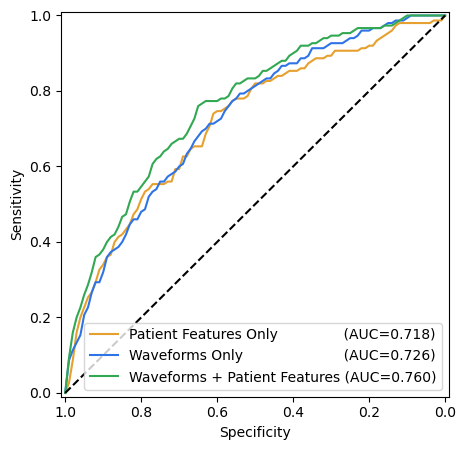

In [13]:

plt.clf()
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(1-base_fpr, tpr_baseline, '#e6a02e', label=f"Patient Features Only               (AUC={round(roc_baseline, 3)})")
ax.plot(1-base_fpr, tpr_waveform, '#2e74e6', label=f"Waveforms Only                       (AUC={round(roc_waveform, 3)})")
auc = '{0:.3f}'.format(round(roc_combined, 3))
ax.plot(1-base_fpr, tpr_combined, '#32a852', label=f"Waveforms + Patient Features (AUC={auc})")

ax.plot([1, 0], [0, 1], 'k--')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Specificity')
ax.invert_xaxis()
ax.legend(loc='lower right')
plt.show()

## Baseline

In [ ]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/test.csv")
ids_baseline = np.array(df["patient_id"].tolist())
y_pred = np.array(df["preds"].tolist())
y_true = np.array(df["actual"].tolist())
df.head(3)

In [72]:
tprs = []
auroc = roc_auc_score(y_true, y_pred)
base_fpr = np.linspace(0, 1, 101)

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Original ROC area: 0.718
Confidence interval for the score: [0.678 - 0.757]


In [5]:
sorted_scores_baseline = sorted_scores

<Figure size 640x480 with 0 Axes>

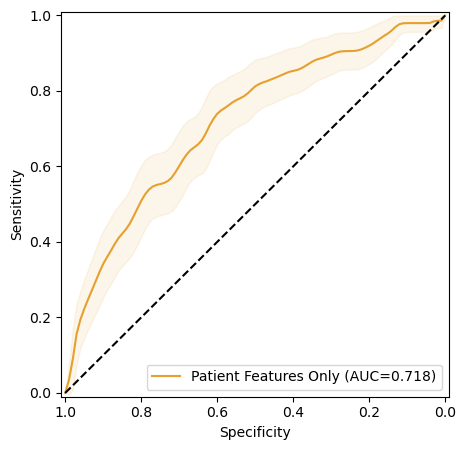

In [73]:

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std * 2, 1)
tprs_lower = mean_tprs - std * 2

plt.clf()
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(1-base_fpr, mean_tprs, '#e6a02e', label=f"Patient Features Only (AUC={round(auroc, 3)})")
ax.fill_between(1-base_fpr, tprs_lower, tprs_upper, color='#e6a02e', alpha=0.1)

ax.plot([1, 0], [0, 1], 'k--')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Specificity')
ax.invert_xaxis()
ax.legend(loc='lower right')
plt.show()

## Waveform

In [ ]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-only/test.csv")
ids_waveform = np.array(df["patient_id"].tolist())
y_pred = np.array(df["preds"].tolist())
y_true = np.array(df["actual"].tolist())
df.head(3)

In [18]:
tprs = []
auroc = roc_auc_score(y_true, y_pred)
base_fpr = np.linspace(0, 1, 101)

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Original ROC area: 0.726
Confidence interval for the score: [0.690 - 0.76]


In [19]:
sorted_scores_waveforms = sorted_scores

<Figure size 640x480 with 0 Axes>

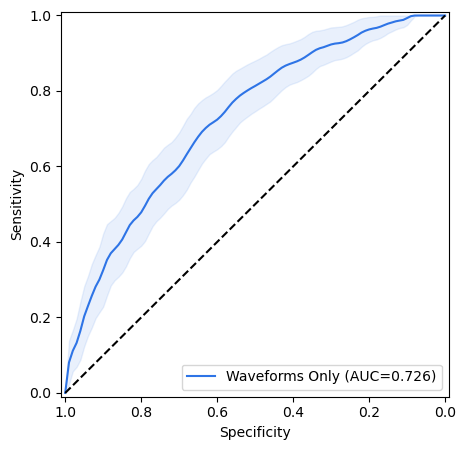

In [16]:

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std * 2, 1)
tprs_lower = mean_tprs - std * 2

plt.clf()
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(1-base_fpr, mean_tprs, '#2e74e6', label=f"Waveforms Only (AUC={round(auroc, 3)})")
ax.fill_between(1-base_fpr, tprs_lower, tprs_upper, color='#2e74e6', alpha=0.1)

ax.plot([1, 0], [0, 1], 'k--')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Specificity')
ax.invert_xaxis()
ax.legend(loc='lower right')
plt.show()

## Waveform + Patient ROC

In [ ]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-demo-vital-risk/test.csv")
ids_best = np.array(df["patient_id"].tolist())
y_pred = np.array(df["preds"].tolist())
y_true = np.array(df["actual"].tolist())
df.head(3)

In [7]:
tprs = []
auroc = roc_auc_score(y_true, y_pred)
base_fpr = np.linspace(0, 1, 101)

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
    fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Original ROC area: 0.760
Confidence interval for the score: [0.727 - 0.794]


In [8]:
sorted_scores_best = sorted_scores

<Figure size 640x480 with 0 Axes>

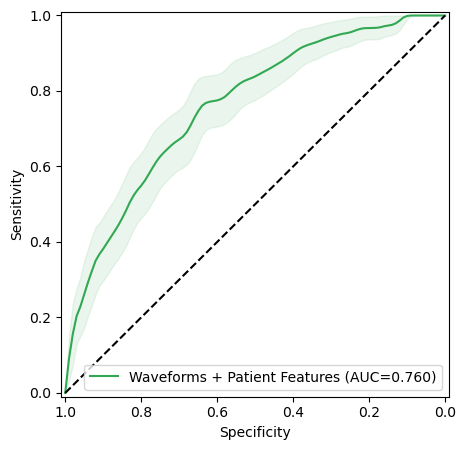

In [79]:

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std * 2, 1)
tprs_lower = mean_tprs - std * 2

plt.clf()
fig, ax = plt.subplots(figsize=(5, 5))
auc = '{0:.3f}'.format(round(roc_combined, 3))
ax.plot(1-base_fpr, mean_tprs, '#32a852', label=f"Waveforms + Patient Features (AUC={auc})")
ax.fill_between(1-base_fpr, tprs_lower, tprs_upper, color='#32a852', alpha=0.1)

ax.plot([1, 0], [0, 1], 'k--')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('Specificity')
ax.invert_xaxis()
ax.legend(loc='lower right')
plt.show()

# Baseline vs Model Statistical Tests

In [83]:
df_nonpretrained = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-1wpp/II/transformer-64-scratch/test.csv")
df_baseline = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/test.csv")
df_waveform = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-only/test.csv")
df_best = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-demo-vital-risk/test.csv")

df_nonpretrained = df_nonpretrained.sort_values(["patient_id"])
df_baseline = df_baseline.sort_values(["patient_id"])
df_waveform = df_waveform.sort_values(["patient_id"])
df_best = df_best.sort_values(["patient_id"])


In [ ]:
df_baseline.head(3)

In [85]:
assert df_nonpretrained["patient_id"].tolist() == df_baseline["patient_id"].tolist()
assert df_waveform["patient_id"].tolist() == df_baseline["patient_id"].tolist()
assert df_best["patient_id"].tolist() == df_baseline["patient_id"].tolist()
print("ok")

ok


In [86]:
df_nonpretrained = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-1wpp/II/transformer-64-scratch/test.csv")
df_baseline = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/test.csv")
df_waveform = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-only/test.csv")
df_best = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-demo-vital-risk/test.csv")

nonpretrained_aucs, nonpretrained_auprcs = get_bootstrap_metrics(df_nonpretrained["preds"].tolist(), df_nonpretrained["actual"].tolist())
baseline_aucs, baseline_auprcs = get_bootstrap_metrics(df_baseline["preds"].tolist(), df_baseline["actual"].tolist())
waveforms_aucs, waveforms_auprcs = get_bootstrap_metrics(df_waveform["preds"].tolist(), df_waveform["actual"].tolist())
best_aucs, best_auprcs = get_bootstrap_metrics(df_best["preds"].tolist(), df_best["actual"].tolist())

100%|██████████| 10000/10000 [05:00<00:00, 33.22it/s]


In [87]:
def get_ci(bootstrap_aucs, bootstrap_auprcs, y_actual, y_pred, alpha=0.95):
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(bootstrap_aucs, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(bootstrap_aucs, p))

    auc_ci = [round(lower, 3), round(upper, 3)]

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_actual, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)

    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(bootstrap_auprcs, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(bootstrap_auprcs, p))

    auprc_ci = [round(lower, 3), round(upper, 3)]

    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    auprc = auc(recall, precision)

    print(f"[Bootstrap] AUC={round(auc_keras, 3)}, 95% CI={auc_ci}; AUPRC={round(auprc, 3)}, 95% CI={auprc_ci}")


In [88]:
get_ci(nonpretrained_aucs, nonpretrained_auprcs, df_nonpretrained["actual"].tolist(), df_nonpretrained["preds"].tolist())

[Bootstrap] AUC=0.659, 95% CI=[0.611, 0.706]; AUPRC=0.206, 95% CI=[0.16, 0.267]


In [89]:
get_ci(baseline_aucs, baseline_auprcs, df_baseline["actual"].tolist(), df_baseline["preds"].tolist())

[Bootstrap] AUC=0.718, 95% CI=[0.673, 0.761]; AUPRC=0.247, 95% CI=[0.196, 0.313]


In [90]:
get_ci(waveforms_aucs, waveforms_auprcs, df_waveform["actual"].tolist(), df_waveform["preds"].tolist())

[Bootstrap] AUC=0.726, 95% CI=[0.684, 0.766]; AUPRC=0.265, 95% CI=[0.204, 0.336]


In [91]:
get_ci(best_aucs, best_auprcs, df_best["actual"].tolist(), df_best["preds"].tolist())

[Bootstrap] AUC=0.76, 95% CI=[0.721, 0.799]; AUPRC=0.321, 95% CI=[0.251, 0.397]


In [99]:
def get_ci_diff(left_aucs, right_aucs, y_actual1, y_pred1, y_actual2, y_pred2, alpha=0.95):
    diffs = np.subtract(left_aucs, right_aucs)
    assert len(diffs) == 10000
    
    p = ((1.0-alpha)/2.0) * 100
    # lower = max(0.0, np.percentile(diffs, p))
#     print(p)
    lower = np.percentile(diffs, p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
#     print(p)
    upper = min(1.0, np.percentile(diffs, p))

    auc_ci = [round(lower, 3), round(upper, 3)]
    
    fpr_keras1, tpr_keras1, _ = roc_curve(y_actual1, y_pred1)
    auc_keras1 = auc(fpr_keras1, tpr_keras1)
    fpr_keras2, tpr_keras2, _ = roc_curve(y_actual2, y_pred2)
    auc_keras2 = auc(fpr_keras2, tpr_keras2)
    print(auc_keras1, auc_keras2)

    print(f"[Bootstrap] DIFF={round(auc_keras1 - auc_keras2, 3)} 95% CI={auc_ci}")
    

In [100]:
# Best - Baseline
get_ci_diff(best_aucs, baseline_aucs, df_best["actual"].tolist(), df_best["preds"].tolist(), df_baseline["actual"].tolist(), df_baseline["preds"].tolist())



0.7604643449419568 0.7175511332227751
[Bootstrap] DIFF=0.043 95% CI=[0.011, 0.076]


In [101]:
# Waveform only - Baseline
get_ci_diff(waveforms_aucs, baseline_aucs, df_waveform["actual"].tolist(), df_waveform["preds"].tolist(), df_baseline["actual"].tolist(), df_baseline["preds"].tolist())



0.7260309563294638 0.7175511332227751
[Bootstrap] DIFF=0.008 95% CI=[-0.039, 0.055]


In [102]:
# Baseline - Non-Pretrained
get_ci_diff(baseline_aucs, nonpretrained_aucs, df_baseline["actual"].tolist(), df_baseline["preds"].tolist(), df_nonpretrained["actual"].tolist(), df_nonpretrained["preds"].tolist())



0.7175511332227751 0.6590049751243781
[Bootstrap] DIFF=0.059 95% CI=[0.008, 0.109]


In [103]:
# Waveform only - Non-Pretrained
get_ci_diff(waveforms_aucs, nonpretrained_aucs, df_waveform["actual"].tolist(), df_waveform["preds"].tolist(), df_nonpretrained["actual"].tolist(), df_nonpretrained["preds"].tolist())



0.7260309563294638 0.6590049751243781
[Bootstrap] DIFF=0.067 95% CI=[0.028, 0.107]


# Lead Time

<Figure size 640x480 with 0 Axes>

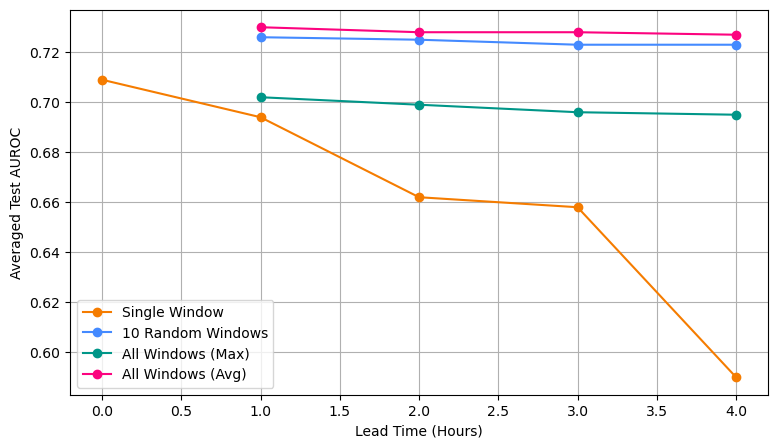

In [88]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(0).clf()
a4_dims = (9, 5)
fig, ax = plt.subplots(figsize=a4_dims)

single_window_x = [0, 1, 2, 3, 4]
single_window_y = [0.709, 0.694, 0.662, 0.658, 0.590]

random_window_x = [1, 2, 3, 4]
random_window_y = [0.726, 0.725, 0.723, 0.723]

all_window_x = [1, 2, 3, 4]
all_window_y = [0.702, 0.699, 0.696, 0.695]

all_window_avg_x = [1, 2, 3, 4]
all_window_avg_y = [0.730, 0.728, 0.728, 0.727]

ax.set_xlabel('Lead Time (Hours)')
ax.set_ylabel('Averaged Test AUROC')

ax.plot(single_window_x, single_window_y, label='Single Window', marker='o', color="#F57C00")
ax.plot(random_window_x, random_window_y, label='10 Random Windows', marker='o', color="#448AFF")
ax.plot(all_window_x, all_window_y, label='All Windows (Max)', marker='o', color="#009688")
ax.plot(all_window_avg_x, all_window_avg_y, label='All Windows (Avg)', marker='o', color="#fc037f")

ax.grid()
ax.legend(loc=0)

plt.show()
# plt.savefig("LT5_AUPRC.eps")

### Logits Over Time

In [ ]:
acs_start_to_outputs = {}
nonacs_start_to_outputs = {}

def add_to_start_to_outputs(k, v, is_acs):
    assert k % 7500 == 0
    if is_acs:
        if k not in acs_start_to_outputs:
            acs_start_to_outputs[k] = []
        acs_start_to_outputs[k].append(v)
    else:
        if k not in nonacs_start_to_outputs:
            nonacs_start_to_outputs[k] = []
        nonacs_start_to_outputs[k].append(v)

for i in range(10):
    df = pd.read_csv(f"/deep/group/ed-monitor/experiments-v8/prna-128-15-leadtime-14400-all/training/{i}/logits.csv")
    df = df.sort_values(["patient_id", "start_offset"])
    start = None
    patient_id_to_start = {}
    for i, row in tqdm(df.iterrows()):
        patient_id = int(row["patient_id"])
        
        label = int(row["label"])
        output = float(row["output"])
        start_offset = float(row["start_offset"])
        if patient_id not in patient_id_to_start:
            patient_id_to_start[patient_id] = start_offset
            start = start_offset

#         # There are quality checks, so make sure we properly account for them
#         num_windows_skipped = int((start_offset - start) / 7500)
#         for w in range(num_windows_skipped):
#             # Waveform was skipped because it was bad...
#             patient_id_to_outputs[patient_id].append(float("nan"))

        if label == 1:
            add_to_start_to_outputs((start_offset - start), output, True)
        else:
            add_to_start_to_outputs((start_offset - start), output, False)


In [ ]:
acs_mean_logits = []
acs_std_logits = []
acs_x = []
nonacs_mean_logits = []
nonacs_std_logits = []
nonacs_x = []

for k in sorted(list(acs_start_to_outputs.keys())):
    acs_mean_logits.append(np.mean(acs_start_to_outputs[k]))
    acs_std_logits.append(np.std(acs_start_to_outputs[k]))
    acs_x.append(k / (60*500))
    if int(k / (60*500)) > 270:
        # stop at 4 hours
        break
    
for k in sorted(list(nonacs_start_to_outputs.keys())):
    nonacs_mean_logits.append(np.mean(nonacs_start_to_outputs[k]))
    nonacs_std_logits.append(np.std(nonacs_start_to_outputs[k]))
    nonacs_x.append(k / (60*500))
    if int(k / (60*500)) > 270:
        # stop at 4.5 hours
        break


In [ ]:
len(np.array(nonacs_x) - np.array(nonacs_mean_logits))

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(0).clf()
a4_dims = (9, 5)
fig, ax = plt.subplots(figsize=a4_dims)

ax.set_xlabel('Lead Time (Minutes)')
ax.set_ylabel('Mean Output Probability')

ax.fill_between(acs_x, np.array(acs_mean_logits) - np.array(acs_std_logits), 
                np.array(acs_mean_logits) + np.array(acs_std_logits), color="#F57C00", alpha=0.1)
ax.fill_between(nonacs_x, np.array(nonacs_mean_logits) - np.array(nonacs_std_logits), 
                np.array(nonacs_mean_logits) + np.array(nonacs_std_logits), color="#448AFF", alpha=0.1)
ax.scatter(acs_x, acs_mean_logits, label='Myocardial Injury', color="#F57C00", s=0.5)
ax.scatter(nonacs_x, nonacs_mean_logits, label='No Myocardial Injury', color="#448AFF", s=0.5)

ax.grid()
ax.legend(loc=0)
plt.show()